### 사용자 기반 협업 필터링 추천시스템

In [43]:
import pandas as pd
import numpy as np
import pymysql
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine

In [44]:
user='root'
pwd='1234'
server='localhost'
db_name='movie_review'

engine = create_engine(f'mysql+pymysql://{user}:{pwd}@{server}/{db_name}?charset=utf8', convert_unicode=True)

connect = engine.connect()

raw_data = pd.read_sql_table('raw_file', connect)
raw_data

,id,user,title,genre,score
0,1178,tnen,기방도령,코미디,4
1,1179,tnen,페이트 스테이 나이트 헤븐즈필 제2장 로스트 버터플라이,애니메이션,1
2,1180,tnen,사바하,미스터리,10
3,1181,tnen,글래스,드라마,10
4,1182,tnen,모털 엔진,액션,10
...,...,...,...,...,...
36070,37248,oran,저수지 게임,스릴러,10
36071,37249,oran,심야식당2,드라마,8
36072,37250,oran,노무현입니다,다큐멘터리,10
36073,37251,oran,붉은 거북,애니메이션,9


In [45]:
%%time
# 10개 평가 이하 영화 제거

def refinding_df(raw_data):
    title_number_df = raw_data.groupby('title').count().sort_values('user')
    #print(title_number_df)
    
    title_under_10 = title_number_df[title_number_df.user <= 10]
    #print(title_under_10)
    
    title_under_10_list = list(title_under_10.index)
    
    for title in title_under_10_list:
        raw_data = raw_data[raw_data['title'] != title]
        
    return raw_data
        
    
raw_df = refinding_df(raw_data)
print(raw_df)

          id  user                           title  genre score
0       1178  tnen                            기방도령    코미디     4
1       1179  tnen  페이트 스테이 나이트 헤븐즈필 제2장 로스트 버터플라이  애니메이션     1
2       1180  tnen                             사바하   미스터리    10
3       1181  tnen                             글래스    드라마    10
4       1182  tnen                           모털 엔진     액션    10
...      ...   ...                             ...    ...   ...
36067  37245  oran                            남한산성    드라마     9
36068  37246  oran                    블레이드 러너 2049     SF     9
36070  37248  oran                          저수지 게임    스릴러    10
36072  37250  oran                          노무현입니다  다큐멘터리    10
36074  37252  oran                              동주    드라마     9

[23637 rows x 5 columns]
Wall time: 23.6 s


In [46]:
df = raw_df.copy()
df.tail(2)

,id,user,title,genre,score
36072,37250,oran,노무현입니다,다큐멘터리,10
36074,37252,oran,동주,드라마,9


In [47]:
df = df.drop(['id'], axis=1)
df.tail(2)

,user,title,genre,score
36072,oran,노무현입니다,다큐멘터리,10
36074,oran,동주,드라마,9


### DATA 탐색

In [48]:
user_num = df.user.unique().shape[0]
movie_num = df.title.unique().shape[0]

print(f'유저의 수는 {user_num} 명이고,\n 영화의 수는 {movie_num}이다.')

유저의 수는 680 명이고,
 영화의 수는 705이다.


### 평점을 많이 남긴 유저 탑10

In [49]:
user_top_10 = df.user.value_counts()[:10]
user_top_10

mari    491
pass    438
inos    384
hws6    328
choi    322
yang    264
alst    231
phs3    225
hang    201
bell    195
Name: user, dtype: int64

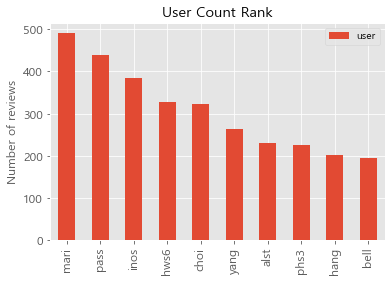

In [50]:
plt.style.use('ggplot')
user_top_10.plot(kind='bar', title='User Count Rank', legend=True, fontsize=12)

plt.ylabel("Number of reviews", fontsize=12)
plt.show()

### 유저들로부터 평점을 많이 받은 영화 탑10

In [51]:
font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
# font_name

rc('font', family=font_name)

df.title.value_counts()

범죄도시                       255
신과함께-죄와 벌                  201
조커                         196
기생충                        176
어벤져스: 엔드게임                 172
                          ... 
땐뽀걸즈                        11
장난스런 키스                     11
주피터 어센딩                     11
주문은 토끼입니까?? ~디어 마이 시스터~     11
우리의 20세기                    11
Name: title, Length: 705, dtype: int64

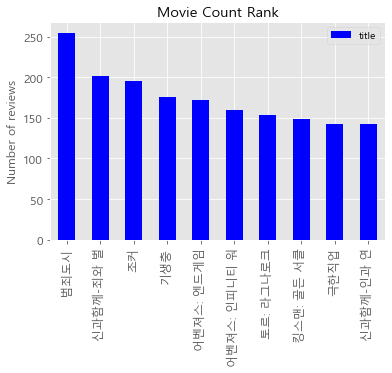

In [52]:
movie_top_10 = df.title.value_counts()[:10]
movie_top_10.plot(kind='bar', title='Movie Count Rank', legend=True, fontsize=12, color='b')

plt.ylabel("Number of reviews", fontsize=12)
plt.show()

### 평점 랭킹

In [53]:
df.score.value_counts()

10    7785
8     3572
9     2577
7     2258
1     2190
6     1946
5     1160
4     1024
2      608
3      517
Name: score, dtype: int64

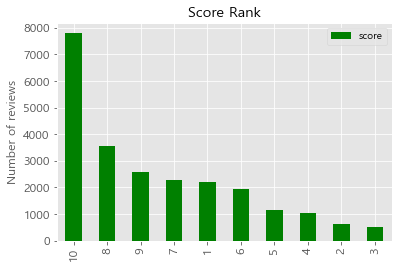

In [54]:
score_ranking = df.score.value_counts()
score_ranking.plot(kind='bar', title='Score Rank', legend=True, fontsize=12, color='g')

plt.ylabel("Number of reviews", fontsize=12)
plt.show()

#### Colaborative Filtering
##### 1. 행렬로 만든다.
##### 2. 추천하고자 하는 유저가 입력되면 코사인 유사도를 이용하여 각 유사도를 구한다.
##### 3. 추천하고자 하는 유저(t)와 K명의 비슷한 유저들의 아이템의 대한 평점을 이용하여 아직 평가하지 않은 영화의 평점을 예측해서 유저에게 추천한다.
#### 4. Validation 한다.

In [55]:
# LabelEncoder를 이용하여 수치화
def execute_labeling(column_name):
    Lec = LabelEncoder()
    df_copy = df.copy()
    
    labeling_data = Lec.fit_transform(df_copy[column_name].values)
    df_label = pd.DataFrame(labeling_data, columns = [column_name+'_label'], index=df_copy.index)

    #print(labeling_data)
    return df_label

df_user = execute_labeling('user')
df_title = execute_labeling('title')

df_copy = df.copy()
df_copy = df_copy.drop(df_copy.columns[[0,1]],axis=1)

df_label = pd.concat([df_user, df_title, df_copy], axis=1)
df_label.tail(5)
    


,user_label,title_label,genre,score
36067,437,104,드라마,9
36068,437,324,SF,9
36070,437,541,스릴러,10
36072,437,119,다큐멘터리,10
36074,437,166,드라마,9


In [56]:
movie_list = list(df['title'].unique())

movie_list = sorted(movie_list, key=str)

movie_list

df_matrix = pd.DataFrame(columns=['user']+movie_list)

df_matrix

,user,#살아있다,0.0MHz,12 솔져스,120BPM,1917,1987,1급기밀,2012,21 브릿지: 테러 셧다운,...,화차,황해,흥부: 글로 세상을 바꾼 자,희생부활자,히든 피겨스,히말라야,히어로,히트,히트맨,"힘을 내요, 미스터 리"


In [57]:
user_num = len(df_label['user_label'].unique())
movie_num = len(df_label['title_label'].unique())

user_score_list = []
for num in range(0, user_num):
    user_score_list = [0 for i in range(movie_num)]
    #print(user_score_list)
    
    df_tmp = df_label[df_label['user_label'] == num]
    
    for j in df_tmp.index:
        user_score_list[df_tmp.loc[j]['title_label']-1] = df_tmp.loc[j]['score']
    
    df_matrix.loc[num] = [num] + user_score_list
        
# user_score_list
type(df_matrix)
    

pandas.core.frame.DataFrame

In [58]:
df_matrix

,user,#살아있다,0.0MHz,12 솔져스,120BPM,1917,1987,1급기밀,2012,21 브릿지: 테러 셧다운,...,화차,황해,흥부: 글로 세상을 바꾼 자,희생부활자,히든 피겨스,히말라야,히어로,히트,히트맨,"힘을 내요, 미스터 리"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,6,0,8
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,675,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
676,676,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
677,677,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
678,678,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### pickle를 사용해서 데이터프레임을 바이너리로 바꾼다.(유틸리티 행렬)

In [59]:
# pickle : 텍스트 상태의 데이터가 아닌 파이썬 객체 자체를 파일로 저장하는 것 입니다.
import pickle

file = df_matrix
directory = open('utilitymatrix', 'wb')
pickle.dump(file, directory) # pickle.dump(객체, 파일)

directory.close()

In [60]:
user_name = list(df['user'].unique())
user_name = sorted(user_name, key=str)

user_name = pd.DataFrame(user_name)
user_name.columns = ['user_name']

file_user = user_name

directory_user = open('user_name', 'wb')
pickle.dump(file_user, directory_user)

directory_user.close()


In [61]:
# user_name, utilitymatrix 불러오기
f = open('utilitymatrix', 'rb')
utilitymatrix = pickle.load(f)
df = utilitymatrix
df.tail(5)



,user,#살아있다,0.0MHz,12 솔져스,120BPM,1917,1987,1급기밀,2012,21 브릿지: 테러 셧다운,...,화차,황해,흥부: 글로 세상을 바꾼 자,희생부활자,히든 피겨스,히말라야,히어로,히트,히트맨,"힘을 내요, 미스터 리"
675,675,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
676,676,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
677,677,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
678,678,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
679,679,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
f = open('user_name', 'rb')
user_name = pickle.load(f)
user_name.tail(5)

,user_name
675,zltm
676,zxcb
677,zzoa
678,zzza
679,zzzz


In [63]:
df_concat = pd.concat([user_name, df], axis=1)
df_concat

,user_name,user,#살아있다,0.0MHz,12 솔져스,120BPM,1917,1987,1급기밀,2012,...,화차,황해,흥부: 글로 세상을 바꾼 자,희생부활자,히든 피겨스,히말라야,히어로,히트,히트맨,"힘을 내요, 미스터 리"
0,0106,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1111,1,0,0,0,0,0,0,0,4,...,0,0,0,0,0,0,0,6,0,8
2,111o,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,0
3,1432,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2gud,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,zltm,675,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
676,zxcb,676,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
677,zzoa,677,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
678,zzza,678,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
# 코사인 유사도를 구하는 함수를 만들어 사용
def cosine_similiarity(data_name):
    from sklearn.metrics.pairwise import cosine_distances
    similiarity = cosine_distances(data_name)
    return similiarity

cos_sim = cosine_similiarity(df)
cos_sim

array([[0.        , 0.96979435, 0.97576889, ..., 0.99807779, 1.        ,
        0.99683127],
       [0.96979435, 0.        , 0.88618697, ..., 0.98288958, 0.9843399 ,
        0.98435626],
       [0.97576889, 0.88618697, 0.        , ..., 0.95169663, 0.96113278,
        0.95896288],
       ...,
       [0.99807779, 0.98288958, 0.95169663, ..., 0.        , 0.00265192,
        0.00276198],
       [1.        , 0.9843399 , 0.96113278, ..., 0.00265192, 0.        ,
        0.00172471],
       [0.99683127, 0.98435626, 0.95896288, ..., 0.00276198, 0.00172471,
        0.        ]])

##### 한 유저 k가 선택되면 k가 평점을 안한 영화의 평점을 예측해서 k에게 높은 것을 추천한다.
##### 다른 유저를 n명의 s 유저를 이용해서

In [65]:
class Basic(object):
    def __init__(self, user_name, neigh_num):
        self.user_name = user_name
        self.neigh_num = neigh_num
        
    # 유저를 입력하면 유저의 번호로 리턴
    def convert_user_name(self):
        user_name_list = list(df_concat['user_name'].unique())
        
        for num in range(len(user_name_list)):
            if user_name_list[num] == self.user_name:
                user_num = num
            
        return user_num
    
    # target 유저와 유사한 유저 n명을 찾고, cosine metrics를 사용하여 이웃한 거리를 찾는다.
    def find_near_neighbor(self):
        from sklearn.neighbors import NearestNeighbors
        user_num = Basic.convert_user_name(self)
        
        KNN = NearestNeighbors(n_neighbors=self.neigh_num, metric='cosine')
        KNN.fit(df)
        
        similiars = {}
        
        # 유사한 유저간의 거리
        similiar_distance, similiar_users = KNN.kneighbors(df)
        similiar_distance = similiar_distance[user_num][1:]
        similiars['sim_distance'] = similiar_distance
        
        # 유사한 유저
        similiar_users = similiar_users[user_num][1:]
        similiars['sim_users'] = list(similiar_users)
        
        return similiars
    
    # target 유저와 유사한 n명으로 이루어진 새로운 데이터프레임 만들고 narray 형식으로 반환
    def near_neighbors_narray(self):
        similiars = Basic.find_near_neighbor(self)
        similiar_users_list = similiars['sim_users']
        similiar_distances = similiars['sim_distance']
        
        columns = list(df.columns)
        new_df = pd.DataFrame(columns=columns)
        
        for i in range(len(similiar_users_list)):
            neighbor_df = df[df['user'] == similiar_users_list[i]]
            neighbor_df = pd.concat([new_df, neighbor_df])
            
            new_df = neighbor_df
        
        narray = new_df.values
        narray = narray[:, 1:]
        
        return narray

In [66]:
user_neighbors = Basic('zzza', 20)
user_neighbors_narray = user_neighbors.near_neighbors_narray()
len(user_neighbors_narray)

19

In [81]:
class Calculation_rating(Basic):
    def __init__(self, user_name, neigh_num):
        Basic.__init__(self, user_name, neigh_num)
        
    def predict_rating(self):
        narray = Basic.near_neighbors_narray(self)
        similiars = Basic.find_near_neighbor(self)
        similiar_distances = similiars['sim_distance']
        
        rating_list = []
        
        # 0 ~ n-1
        for col_num in range(narray.shape[1]):
            sum = 0
            rating = 0
            
            for i in range(1, len(narray[:, col_num])):
                sum += float(narray[:, col_num][i]) * float(similiar_distances[i])
            
            rating = sum / similiar_distances.sum()
            
            if rating < 0:
                rating = 0
            elif rating > 10:
                rating = 10
            else:
                rating = int(rating)
            rating_list.append(rating)
            
        return rating_list
    
    # 타겟 유저의 평점을 리스트로 변환
    def orginal_rating(self):
        user_num = Basic.convert_user_name(self)
        
        # target 유저의 평점을 narray로 변환
        target_df = df[df['user'] == user_num]
        target_narray = target_df.values
        target_narray = target_narray[:, 1:]
        
        # narray로 변환된 유저의 평점을 리스트로 변환
        target_user_rating_list = []
        
        for i in range(target_narray.shape[1]):
            raw_rating = int(target_narray[0][i])
            target_user_rating_list.append(raw_rating)
            
        return target_user_rating_list


In [82]:
user_tnen = Calculation_rating('tnen', 6)
print(user_tnen)
user_tnen.predict_rating()

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
